## Face Mask Segmentation

Task is to predict the boundaries(mask) around the face in a given image.

## Dataset

Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

Install certain Versios of Tensorflow and Numpy to avoid errors

In [0]:
!pip install numpy==1.16.1

%tensorflow_version 1.x

In [1]:
import keras
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Reshape, UpSampling2D, Concatenate
from keras import backend as K

Using TensorFlow backend.


In [0]:
!pip install tensorflow==1.14

In [0]:
import tensorflow as tf
print(tf.__version__) 

## Mount Google drive if you are using google colab

In [2]:
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Change current working directory to project folder (1 mark)

In [0]:
import os
os.chdir('drive/My Drive/Colab Notebooks/Computer_Vision')

## Load the "images.npy" file (2 marks)

In [0]:
import numpy as np
data = np.load('images.npy')

## Check one sample from the loaded "images.npy" file (2 marks)

In [7]:
print(data[10][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


## Set image dimensions (1 mark)

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
ALPHA = 1.0

## Create features and labels

Here feature is the image.
The label is the mask.
Images will be stored in "X_train" array.
Masks will be stored in "masks" array.

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH,3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

Print the shape of X_train and mask array (1 mark)

In [9]:
print(X_train.shape)

(409, 224, 224, 3)


In [10]:
print(masks.shape)

(409, 224, 224)


Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

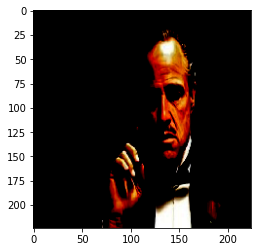

In [11]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

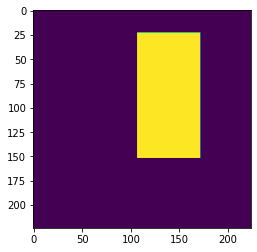

In [12]:
pyplot.imshow(masks[n])

Create the model (10 marks)
Add MobileNet as model with below parameter values
input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
include_top: False
alpha: 1.0
weights: "imagenet"
Add UNET architecture layers
This is the trickiest part of the project, you need to research and implement it correctly

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model

#define unet function and assign MobileNet model 
#will check the architecture by adding one by one up sampling layer at a time
# Step-0 (Encoder part) (we can write all steps in one at a time just to show step by step)
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")
    for layer in model.layers:
        layer.trainable = trainable
    # model.summary()
  
    block_1 = model.get_layer("conv_pw_1_relu").output
    block0 = model.get_layer("conv_pw_3_relu").output
    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block_1])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)
    return Model(inputs=model.input, outputs=x)


Call the create_model function

In [14]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
17227776/17225924 [==============================] - 3s 0us/step
(?, 14, 14, 1536)
(?, 28, 28, 1792)
(?, 56, 56, 1920)
(?, 112, 112, 1984)
(?, 224, 224, 1984)
(?, 224, 224)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
_

Define dice coefficient function (5 marks)

In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

Define loss

In [0]:
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

Compile the model (2 marks)
Complie the model using below parameters
loss: use the loss function defined above
optimizers: use Adam optimizer
metrics: use dice_coefficient function defined above

In [0]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

EPOCHS = 50
optimizer = Adam(lr=1e-3)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

Define checkpoint and earlystopping

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

Fit the model (2 marks)
Fit the model using below parameters
epochs: you can decide
batch_size: 1
callbacks: checkpoint, reduce_lr, stop

In [19]:
model.fit(X_train, masks, epochs=EPOCHS, verbose=1, batch_size=1, callbacks=[checkpoint, reduce_lr, stop])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
408/409 [============================>.] - ETA: 1s - loss: 1.2581 - dice_coefficient: 0.5056
Epoch 00001: loss improved from inf to 1.25816, saving model to model-1.26.h5
409/409 [==============================] - 698s 2s/sample - loss: 1.2582 - dice_coefficient: 0.5052
Epoch 2/50
408/409 [============================>.] - ETA: 1s - loss: 0.8709 - dice_coefficient: 0.5976
Epoch 00002: loss improved from 1.25816 to 0.87037, saving model to model-0.87.h5
409/409 [==============================] - 711s 2s/sample - loss: 0.8704 - dice_coefficient: 0.5978
Epoch 3/50
408/409 [============================>.] - ETA: 1s - loss: 0.7405 - dice_coefficient: 0.6429
Epoch 00003: loss improved from 0.87037 to 0.73966, saving model to model-0.74.h5
409/409 [==============================] - 721s 2s/sample - loss: 0.7397 - dice_coefficient: 0.6432
Epoch 4/50
408/409 [============================>.] 

Get the predicted mask for a sample image (3 marks)


In [0]:
n = 10
sample_image = X_train[n]

In [0]:
ft = preprocess_input(np.array(sample_image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([sample_image]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

Impose the mask on the image (3 marks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


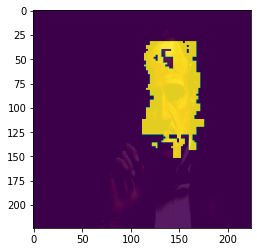

In [22]:
import matplotlib.pyplot as plt
out_image = sample_image
plt.imshow(out_image)
plt.imshow(pred_mask, alpha=0.9)